# What patterns exist between energy consumption and generation?

## Goals (2 min)

By the end of ths case, we hope to have properly introduced the basics of manipulating data using `pandas` and the basics of plotting using the `matplotlib` and `seaborn` libraries.

You should also begin to develop a sense of which plots to use for displaying certain types of information. This will help you write better reports and to communicate your ideas and analysis much more clearly to non-data professionals.

## Introduction (5 min)

**Business Context.** Energy supply and demand is a hotly debated topic across world governments and political parties. You are an analyst for a the Department of Energy (DoE), and are responsible for discerning patterns in electric power generation and consumption across different energy sources as well as across sectors of the U.S. economy in order to help drive government initiatives.

**Business Problem.** Your boss would like you answer the following question: **"Given patterns in energy consumption across sectors and time, how should we allocate government resources towards nuclear electricity generation?"** and generate files of graphs that will make it as easy as possible for him to explain your findings to the non-technical politicians so they can allocate resources appropriately across the country.

**Analytical Context.** You are given data in CSV format from the Energy Information Administration (EIA) for both energy consumption and net electricity generation, where energy consumption is broken down by sector and electricity generation is broken down by source. In this case, you will: (1) pre-process the data to transform it into a format amenable to later analysis; (2) utilize simple plotting functionality in Python to explore relationships between energy consumption in the electric power sector and electricity generation from nuclear electric power; (3) identify any patterns in energy usage and generation and how they change over time; and finally, (4) use advanced plotting functionality to determine which sectors consume the most energy and how this has evolved over time.

In [1]:
# Load packages
import os
import pandas as pd
import numpy as np

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

## Getting started with the Energy Information Administration (EIA) data (10 min)

The consumption and generation data are each given on a monthly basis in ```data/energy_consumption.csv``` and ```data/electricity_generation.csv```. The data's contents and some useful characteristics to note about the data are as follows:

### data/energy_consumption.csv
- Contains monthly energy consumption by sector for the U.S.
- Energy consumption is the use of energy as a source of heat or power or as an input in the manufacturing process
- Primary energy is first accounted for energy in a statistical energy balance, before any transformation to secondary or tertiary forms of energy
- Total energy consumption in sectors consists of primary energy consumption, electricity retail sales, and electrical system energy losses

### data/electricity_generation.csv
- Contains monthly net electricity generation for all sectors in the U.S.
- Net electricity generation is the amount of gross electricity generation less station use (the electric energy consumed at the generating station(s) for station service or auxiliaries)
- Btu stands for British Thermal Unit

The columns in the tables are:

1. **MSN:** Mnemonic Series Names (see https://www.eia.gov/state/seds/sep_use/notes/use_a.pdf for more information)
2. **YYYYMM:** The month of the energy use
3. **Value:** The amount of energy consumed/generated
4. **Column_Order:** The order of columns used in the official EIA reports
5. **Description:** The description of which sector consumed/generated the electricity
6. **Unit:** The unit of energy used for the value

(Source: https://www.eia.gov/totalenergy/data/monthly/pdf/sec13.pdf)

Let's begin by loading the data into Python:

In [2]:
# Load the data into python
energy_consumption_file = os.path.join(os.getcwd(),'data/energy_consumption.csv')        
electricity_generation_file = os.path.join(os.getcwd(),'data/electricity_generation.csv')

energy_df = pd.read_csv(energy_consumption_file)
electricity_df = pd.read_csv(electricity_generation_file)

The ```Description``` column gives sector (energy consumption) or source (electricity generation) description. Let's look at all the available description values for each dataset to understand what data is available.

In [3]:
# Look at energy (consumption) data
energy_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,TXRCBUS,194913,4460.588,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
1,TXRCBUS,195013,4829.528,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
2,TXRCBUS,195113,5104.680,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
3,TXRCBUS,195213,5158.406,1,Primary Energy Consumed by the Residential Sector,Trillion Btu
4,TXRCBUS,195313,5052.749,1,Primary Energy Consumed by the Residential Sector,Trillion Btu


In [4]:
# Get all unique descriptions available
print(energy_df['Description'].unique())

['Primary Energy Consumed by the Residential Sector'
 'Total Energy Consumed by the Residential Sector'
 'Primary Energy Consumed by the Commercial Sector'
 'Total Energy Consumed by the Commercial Sector'
 'Primary Energy Consumed by the Industrial Sector'
 'Total Energy Consumed by the Industrial Sector'
 'Primary Energy Consumed by the Transportation Sector'
 'Total Energy Consumed by the Transportation Sector'
 'Primary Energy Consumed by the Electric Power Sector'
 'Energy Consumption Balancing Item' 'Primary Energy Consumption Total']


In [5]:
# Look at electricity (generation) data
electricity_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLETPUS,194913,135451.32,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
1,CLETPUS,195013,154519.994,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
2,CLETPUS,195113,185203.657,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
3,CLETPUS,195213,195436.666,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
4,CLETPUS,195313,218846.325,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours


In [6]:
# Get all unique descriptions available
print(electricity_df['Description'].unique())

['Electricity Net Generation From Coal, All Sectors'
 'Electricity Net Generation From Petroleum, All Sectors'
 'Electricity Net Generation From Natural Gas, All Sectors'
 'Electricity Net Generation From Other Gases, All Sectors'
 'Electricity Net Generation From Nuclear Electric Power, All Sectors'
 'Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors'
 'Electricity Net Generation From Conventional Hydroelectric Power, All Sectors'
 'Electricity Net Generation From Wood, All Sectors'
 'Electricity Net Generation From Waste, All Sectors'
 'Electricity Net Generation From Geothermal, All Sectors'
 'Electricity Net Generation From Solar, All Sectors'
 'Electricity Net Generation From Wind, All Sectors'
 'Electricity Net Generation Total (including from sources not shown), All Sectors']


Here we see that we have a variety of energy consumption sectors, as well as a variety of energy generation sources for each sector. We are specifically interested in nuclear electric power generation and electric power consumption as the DoE is considering nuclear power projects.

## Pre-processing data to simplify analysis moving forward (25 min)

In the real world, we often do not have the luxury of dealing with perfectly clean and formatted data. Therefore, we will need to perform some operations on provided data to get it into a format amenable to further analysis.

For example, the ```Value``` column is a numerical value but is currently in string format which makes performing math operations on it more diffcult. This is because this column is missing some values, which are recorded as 'Not Available':

In [7]:
electricity_df[electricity_df['Value'] == 'Not Available'].groupby(['Description']).count()

,MSN,YYYYMM,Value,Column_Order,Unit
Description,,,,,
"Electricity Net Generation From Geothermal, All Sectors",11,11,11,11,11
"Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors",245,245,245,245,245
"Electricity Net Generation From Other Gases, All Sectors",232,232,232,232,232
"Electricity Net Generation From Solar, All Sectors",167,167,167,167,167
"Electricity Net Generation From Waste, All Sectors",21,21,21,21,21
"Electricity Net Generation From Wind, All Sectors",154,154,154,154,154


Let's change these values to be numerical and leave the 'Not Available' as nulls so that we can drop them. To do this, we will be using the **`.apply()` function**. The [apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) function takes in a function as the main arugument, then applies it to every element along the first axis. For a Series, this means that said function is applied to every value (as it only has one axis). For a DataFrame, the first axis are along the columns.

To operate on the rows instead, you need to specify `axis=1` as an argument to `.apply()`. For example, we can change all string types to float types in the `Value` column as follows: 

In [8]:
def string_to_float(r):
    return float(r['Value']) if r['Value'] != 'Not Available' else None

energy_df['Value'] = energy_df.apply(string_to_float, axis=1)
electricity_df['Value'] = electricity_df.apply(string_to_float, axis=1)

Alternatively, we can use **lambda functions** as a direct input to the ```apply()``` function. A lambda function is simply Python syntax for defining functions in a single line. You can think of it as an analogue to inline ```if``` statements or list comprehensions. Here is a simple illustration:

In [50]:
arr = [1,2,3,4,5]

def double(x):
    return x*2
    
print(list(map(double, arr)))

[2, 4, 6, 8, 10]


versus

In [51]:
print(list(map(lambda x: x*2, arr)))

[2, 4, 6, 8, 10]


When you have relatively simple functions that are only used once, it is best to use the ```lambda``` keyword so that they remain anonymous (not bound to a name) and fit on one line for ease of reading. We will now apply ```Lambda``` functions directly as an argument to ```.apply()```. Note that we don't need ```axis=1``` in the following example because we are operating on the column directly which is a Series:
</span>

In [9]:
energy_df['Value'] = energy_df['Value'].apply(lambda x: float(x) if x != 'Not Available' else None)
electricity_df['Value'] = electricity_df['Value'].apply(lambda x: float(x) if x != 'Not Available' else None)

Now, let's get rid of the null values:

In [10]:
energy_df = energy_df.dropna()
electricity_df = electricity_df.dropna()

### Exercise 1 (5 min):

Another suboptimal characteristic of the data as provided is that the ```YYYYMM``` column for the month and year is difficult to use. Using ```apply()``` and ```lambda```, write code to create a new column named ```YYYY``` and ```MM``` to both Dataframes, where the new columns are the year and month of the observation as strings. For instance if the ```YYYYMM``` value is 201407, then the value in the new column for the year would be '2014' and the value in the new column for the month would be '07'. Recall that you can access the first 4 characters of some string ```my_string``` using ```my_string[:4]```.

**Answer.** One possible solution is given below:

In [11]:
# Extract the month
energy_df['MM'] = energy_df['YYYYMM'].apply(lambda x: int(str(x)[-2:]))
electricity_df['MM'] = electricity_df['YYYYMM'].apply(lambda x: int(str(x)[-2:]))

# Extract the year
energy_df['YYYY'] = energy_df['YYYYMM'].apply(lambda x: int(str(x)[:-2]))
electricity_df['YYYY'] = electricity_df['YYYYMM'].apply(lambda x: int(str(x)[:-2]))

Moreover, notice that the existing descriptions are quite long. We might as well use some abbreviations:

- PEC: Primary Energy Consumption
- TEC: Total Energy Consumption
- ENG: Electricity Net Generation

Let's change the ```Description``` column to use the abbreviated form and reduce the clutter of the output. This will be useful later on when we are making plots and want clean organized figures. We will also remove columns (```MSN``` and ```Column_Order```) and rows (descriptions with 'Energy Balance') that are not relevant to our data analysis:

In [12]:
# Rename Descriptions for the energy data
energy_short_dict = {'Primary Energy Consumed by the Commercial Sector': 'PEC Commercial Sector',
              'Primary Energy Consumed by the Electric Power Sector': 'PEC Electric Power Sector',
              'Primary Energy Consumed by the Industrial Sector': 'PEC Industrial Sector',
              'Primary Energy Consumed by the Residential Sector': 'PEC Residential Sector',
              'Primary Energy Consumed by the Transportation Sector': 'PEC Transportation Sector',
              'Primary Energy Consumption Total': 'PEC Total',
              'Total Energy Consumed by the Commercial Sector': 'TEC Commercial Sector',
              'Total Energy Consumed by the Industrial Sector': 'TEC Industrial Sector',
              'Total Energy Consumed by the Residential Sector': 'TEC Residential Sector',
              'Total Energy Consumed by the Transportation Sector': 'TEC Transportation Sector'}

# remove undesired description
clean_energy_df = energy_df[energy_df['Description'].isin(energy_short_dict.keys())].copy()

# remove columns
remove_columns = ['MSN', 'Column_Order']
clean_energy_df = clean_energy_df.drop(remove_columns, axis=1)

# Clean up names by shortening description
clean_energy_df['Description'] = clean_energy_df['Description'].apply(lambda x: energy_short_dict[x])
clean_energy_df.head()

,YYYYMM,Value,Description,Unit,MM,YYYY
0,194913,4460.588,PEC Residential Sector,Trillion Btu,13,1949
1,195013,4829.528,PEC Residential Sector,Trillion Btu,13,1950
2,195113,5104.680,PEC Residential Sector,Trillion Btu,13,1951
3,195213,5158.406,PEC Residential Sector,Trillion Btu,13,1952
4,195313,5052.749,PEC Residential Sector,Trillion Btu,13,1953


In [13]:
# Rename Descriptions for the electricity data
electricity_short_dict = {'Electricity Net Generation From Coal, All Sectors': 'ENG Coal',
                          'Electricity Net Generation From Conventional Hydroelectric Power, All Sectors': 'ENG HE Power',
                          'Electricity Net Generation From Geothermal, All Sectors': 'ENG Geothermal',
                          'Electricity Net Generation From Hydroelectric Pumped Storage, All Sectors': 'ENG HE Pumped Storage',
                          'Electricity Net Generation From Natural Gas, All Sectors': 'ENG Natural Gas',
                          'Electricity Net Generation From Nuclear Electric Power, All Sectors': 'ENG Nuclear Electric Power',
                          'Electricity Net Generation From Other Gases, All Sectors': 'ENG Other Gases',
                          'Electricity Net Generation From Petroleum, All Sectors': 'ENG Petroleum',
                          'Electricity Net Generation From Solar, All Sectors': 'ENG Solar',
                          'Electricity Net Generation From Waste, All Sectors': 'ENG Waste',
                          'Electricity Net Generation From Wind, All Sectors': 'ENG Wind',
                          'Electricity Net Generation From Wood, All Sectors': 'ENG Wood',
                          'Electricity Net Generation Total (including from sources not shown), All Sectors': 'ENG Total'}

clean_electricity_df = electricity_df.copy()

# remove columns
remove_columns = ['MSN', 'Column_Order']
clean_electricity_df = clean_electricity_df.drop(remove_columns, axis=1)

# Clean up names by shortening description
clean_electricity_df['Description'] = clean_electricity_df['Description'].apply(lambda x: electricity_short_dict[x])
clean_electricity_df.head()

,YYYYMM,Value,Description,Unit,MM,YYYY
0,194913,135451.320,ENG Coal,Million Kilowatthours,13,1949
1,195013,154519.994,ENG Coal,Million Kilowatthours,13,1950
2,195113,185203.657,ENG Coal,Million Kilowatthours,13,1951
3,195213,195436.666,ENG Coal,Million Kilowatthours,13,1952
4,195313,218846.325,ENG Coal,Million Kilowatthours,13,1953


Now that we've decluttered the output, we can now easily see that the month column has some '13' values which is obviously one more than the Gregorian calendar. Let's try to figure out what is going on. We will group the energy generation by year and month to investigate:

In [14]:
clean_electricity_df.groupby(['YYYY', 'Description']).count().head(20)

YYYYMM  Value  Unit  MM
YYYY Description                                        
1949 ENG Coal                         1      1     1   1
     ENG HE Power                     1      1     1   1
     ENG Natural Gas                  1      1     1   1
     ENG Nuclear Electric Power       1      1     1   1
     ENG Petroleum                    1      1     1   1
     ENG Total                        1      1     1   1
     ENG Wood                         1      1     1   1
1950 ENG Coal                         1      1     1   1
     ENG HE Power                     1      1     1   1
     ENG Natural Gas                  1      1     1   1
     ENG Nuclear Electric Power       1      1     1   1
     ENG Petroleum                    1      1     1   1
     ENG Total                        1      1     1   1
     ENG Wood                         1      1     1   1
1951 ENG Coal                         1      1     1   1
     ENG HE Power                     1      1     1   1
     ENG Natural Gas                  1      1     1   1
     ENG Nuclear Electric Power       1      1     1   1
     ENG Petroleum                    1      1     1   1
     ENG Total                        1      1     1   1

In [15]:
clean_electricity_df.groupby(['YYYY', 'Description']).count().tail(20)

YYYYMM  Value  Unit  MM
YYYY Description                                        
2018 ENG Other Gases                 13     13    13  13
     ENG Petroleum                   13     13    13  13
     ENG Solar                       13     13    13  13
     ENG Total                       13     13    13  13
     ENG Waste                       13     13    13  13
     ENG Wind                        13     13    13  13
     ENG Wood                        13     13    13  13
2019 ENG Coal                        10     10    10  10
     ENG Geothermal                  10     10    10  10
     ENG HE Power                    10     10    10  10
     ENG HE Pumped Storage           10     10    10  10
     ENG Natural Gas                 10     10    10  10
     ENG Nuclear Electric Power      10     10    10  10
     ENG Other Gases                 10     10    10  10
     ENG Petroleum                   10     10    10  10
     ENG Solar                       10     10    10  10
     ENG Total                       10     10    10  10
     ENG Waste                       10     10    10  10
     ENG Wind                        10     10    10  10
     ENG Wood                        10     10    10  10

It seems that old years only have one data point while recent ones have 13. If you read the documentation, this comes from the fact that a month of 13 designates the yearly total for that year. That is, the row with ```MM``` equal to 13 should be the sum of rows with ```MM``` in the range 1 - 12. Additionally, for the first 20 or so years, they didn't keep track of monthly statistics.

### Exercise 2 (8 min):

Write code to validate that the sum of the values in months 1 - 12 is equal to that in "month" 13, then remove those "month" 13 rows for both datasets. 

**Hint:** The ```.groupby()``` pandas function will be helpful here as some years won't sum perfectly due to rounding errors.

**Answer.** One possible solution is given below:

In [16]:
monthly_stats = clean_electricity_df[clean_electricity_df['MM'] != 13].groupby(['Description', 'YYYY']).sum().reset_index()
yearly_stats = clean_electricity_df[clean_electricity_df['MM'] == 13].groupby(['Description', 'YYYY']).sum().reset_index()

merged_stats = pd.merge(left=monthly_stats, right=yearly_stats, on=['YYYY', 'Description'], how='inner', suffixes=('_monthly', '_yearly'))

tol = 0.01

print('Does it sum to month 13:')
print((abs(merged_stats['Value_monthly'] - merged_stats['Value_yearly']) <= tol).all())

clean_energy_df = clean_energy_df[clean_energy_df['MM'] != 13]
clean_electricity_df = clean_electricity_df[clean_electricity_df['MM'] != 13]

Does it sum to month 13:
True


Now that we have processed our data, we can begin visualizing it to see if we can uncover hidden patterns.

## Identifying the relationship between energy consumption and generation (12 min)

Recall that our boss wants to determine how to optimally allocate the DoE's electricity generation resources given consumption patterns. It makes sense to look at how consumption patterns have generally varied across time and sectors in order to drive electricity generation strategy. Let's analyze this by doing some basic plotting in Python's ubiquitous plotting package [matplotlib](https://matplotlib.org/contents.html). Given that we represent the DoE and are investigating nuclear energy, one thing that makes sense to look at is the relationship between energy consumption by each major sector and the net energy generation from nuclear electric power.

We will first use a 2D scatterplot to visualize the data. Scatterplots are versatile and are often the first type of plot one uses when visualizing a dataset. We'll start with the electric power sector; we'll build a scatterplot with ```PEC Electric Power Sector``` on the y-axis, and ```ENG Nuclear Electric Power``` on the x-axis. This will allow us to see how electric power energy consumption moves in relation to nuclear electric power generation:

In [17]:
# Define the consumption and generation categories we are interested in
consume_category = 'PEC Electric Power Sector'
generate_category = 'ENG Nuclear Electric Power'

# Select the Electric Power Sector for energy consumption
consume_df = clean_energy_df[clean_energy_df['Description'] == consume_category][['YYYYMM','Value']].reset_index(drop=True)

# Select nuclear electric power for energy consumption (all sectors)
generate_df = clean_electricity_df[clean_electricity_df['Description'] == generate_category][['YYYYMM','Value']].reset_index(drop=True)

# Merge into one data frame for ease of plotting
merged_df = pd.merge(consume_df, generate_df, how='left', on=['YYYYMM'], suffixes=('_CONSUME','_GENERATE'))

merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE
0,197301,1691.096,6246.251
1,197302,1511.458,5928.069
2,197303,1559.159,6649.007
3,197304,1470.152,5876.392
4,197305,1551.631,5696.657


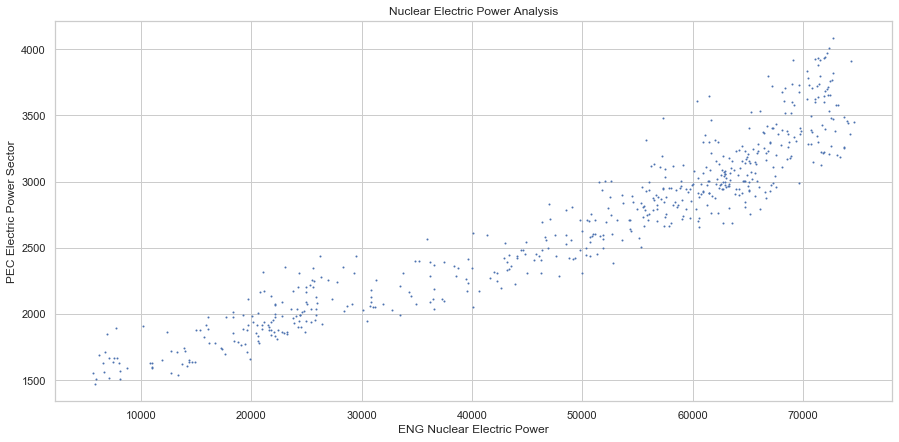

In [18]:
# Create basic scatter plot to view two-variable relationship
plt.figure(figsize=(15, 7))
plt.scatter(merged_df['Value_GENERATE'], merged_df['Value_CONSUME'], s=1)
plt.title('Nuclear Electric Power Analysis');
plt.xlabel(generate_category);
plt.ylabel(consume_category);

### Exercise 3 (7 min):

Write code to produce additional scatterplots that give insight into the relationship between the energy consumption for the commercial sector and nuclear electric power net energy generation. Is the relationship between these variables stronger or weaker when compared to the electric power sector's result? What might this mean in terms of a potential DoE recommendation?

**Answer.** One possible solution is shown below:

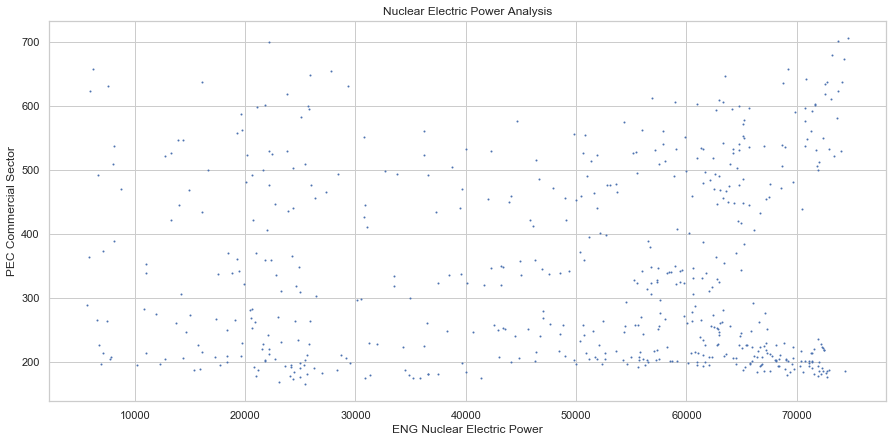

In [19]:
consume_category = 'PEC Commercial Sector'
generate_category = 'ENG Nuclear Electric Power'

# Select electric power sector for energy consumption 
consume_df = clean_energy_df[clean_energy_df['Description'] == consume_category][['YYYYMM','Value']].reset_index(drop=True)

# Select electricity generated by all sectors
generate_df = clean_electricity_df[clean_electricity_df['Description'] == generate_category][['YYYYMM','Value']].reset_index(drop=True)

# Merge into one data frame for ease of plotting
merged_df = pd.merge(consume_df, generate_df, how='left', on=['YYYYMM'], suffixes=('_CONSUME','_GENERATE'))

# Basic scatter plot
plt.figure(figsize=(15, 7))
plt.scatter(merged_df['Value_GENERATE'], merged_df['Value_CONSUME'], s=1)
plt.title('Nuclear Electric Power Analysis');
plt.xlabel(generate_category);
plt.ylabel(consume_category);

From these plots we see that commercial sector consumption levels do not track nuclear electric power generation levels very well, while electric power sector levels do. This may mean that it is critical for the DoE to dedicate significant resources towards electricity generation for the electric power sector, as it seems to be a significant driver of marginal demand for nuclear power, whereas it is not so important for the DoE to dedicate resources towards electricity generation for the commercial sector.

## Trends in energy consumption and generation over time (15 min)

While a scatterplot helps us visualize the relationship between two variables, it does not allow us to look at something across time. For this, we will a different tool: the **line plot**.

A line plot is excellent for viewing time series data and will help us determine trends and cyclical patterns across time for both electric power sector energy consumption and nuclear electric power energy generation.

Let's build a line plot for each of these series:

In [20]:
consume_category = 'PEC Electric Power Sector'
generate_category = 'ENG Nuclear Electric Power'

# Select electric power sector for energy consumption 
consume_df = clean_energy_df[clean_energy_df['Description'] == consume_category][['YYYYMM','Value']].reset_index(drop=True)

# Select electricity generated by all sectors
generate_df = clean_electricity_df[clean_electricity_df['Description'] == generate_category][['YYYYMM','Value']].reset_index(drop=True)

# Merge into one data frame for ease of plotting
merged_df = pd.merge(consume_df, generate_df, how='left', on=['YYYYMM'], suffixes=('_CONSUME','_GENERATE'))

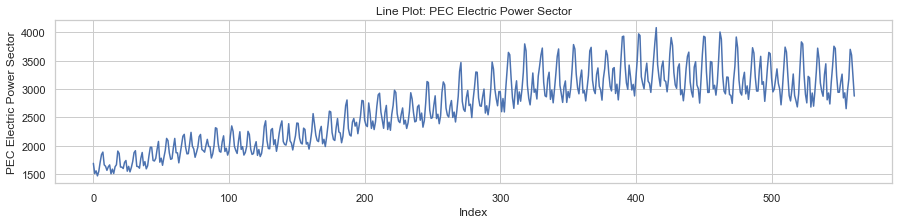

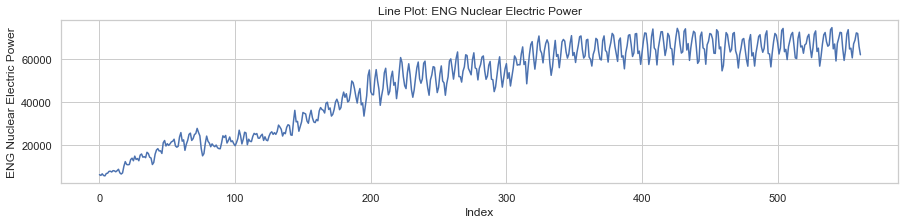

In [21]:
# Line plot for energy consumption over time
plt.figure(figsize=(15,3))
plt.plot(merged_df['Value_CONSUME'])
plt.title('Line Plot: ' + consume_category)
plt.xlabel('Index');
plt.ylabel(consume_category);

# Line plot for electricity generation over time
plt.figure(figsize=(15,3))
plt.plot(merged_df['Value_GENERATE'])
plt.title('Line Plot: ' + generate_category)
plt.xlabel('Index');
plt.ylabel(generate_category);

Notice that we see that both energy consumption and generation are increasing over time, with a strong cyclical trend (observe the oscillating nature of the time series). However, the way in which we've plotted these line plots does not allow for nice formatting and interpretation of the x-axis. We'd like the x-axis to be dates rather than simply the DataFrame index value.

### Enhancing time series visualization by including formatted dates in the line plot

Luckily, Python allows us to nicely format dates for display in the plot. This is useful when including work in a report that will be presented to an audience, as it is more professional and easier to understand for non-technical people.

In [22]:
# Convert YYYYMM string to datetime format
merged_df['YYYYMM_dt'] = merged_df['YYYYMM'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m"))
merged_df.head()

,YYYYMM,Value_CONSUME,Value_GENERATE,YYYYMM_dt
0,197301,1691.096,6246.251,1973-01-01
1,197302,1511.458,5928.069,1973-02-01
2,197303,1559.159,6649.007,1973-03-01
3,197304,1470.152,5876.392,1973-04-01
4,197305,1551.631,5696.657,1973-05-01


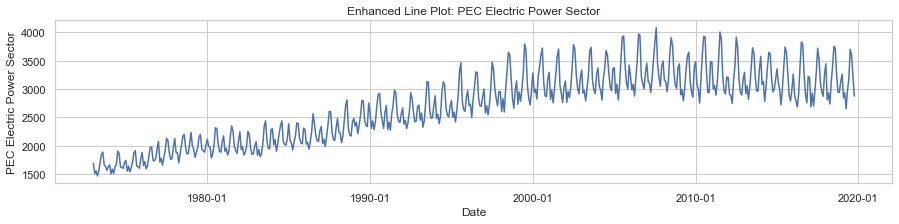

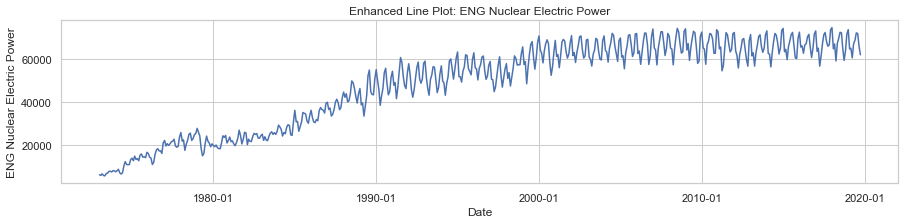

In [23]:
# Enhanced line plot for energy consumption over time
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(merged_df['YYYYMM_dt'], merged_df['Value_CONSUME'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # format x-axis display
plt.title('Enhanced Line Plot: ' + consume_category)
plt.xlabel('Date');
plt.ylabel(consume_category);

# Enhanced line plot for electricity generation over time
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(merged_df['YYYYMM_dt'], merged_df['Value_GENERATE'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # format x-axis display
plt.title('Enhanced Line Plot: ' + generate_category)
plt.xlabel('Date');
plt.ylabel(generate_category);

### Exercise 4 (5 min):

Write code to determine if the oscillations in the variable ```PEC Electric Power Sector``` are getting larger over time (**Hint:** use ```merged_df['Value_CONSUME'].pct_change()```). Plot the percentage change for each month across time, using the formated dates on the x-axis.

**Answer.** One possible solution is shown below:

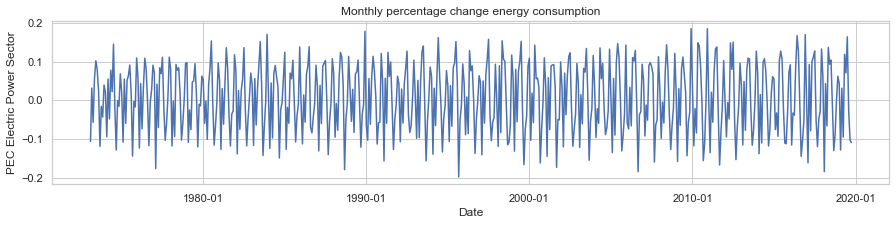

In [24]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(merged_df['YYYYMM_dt'], merged_df['Value_CONSUME'].pct_change())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # format x-axis display
plt.title('Monthly percentage change energy consumption')
plt.xlabel('Date');
plt.ylabel(consume_category);

We see that the percentage changes from month to month are not growing significantly over time. This indicates that the percentage fluctuations in energy consumption remain relatively constant, even as the total amount of energy used across time has grown.

In light of this, one useful statistic to better understand energy usage relative to electricity generation is the ratio of energy consumed to electricity generated. This may give us insight into how well supply meets demand and how nuclear power may expand and contract electricity generation in high or low demand periods.

## Analyzing the ratio of energy consumed to electricity generated (10 min)

Let's calculate the ratio of energy consumed over energy generated. Using ```pandas```'s ```describe()``` method, let's take a look at some summary statistics which describe the distribution of this ratio. Understanding the distribution of the ratio will allow us to see how energy consumption and electricity generation deviate relative to one another. We will continue to look at the ```PEC Electric Power Sector``` energy consumption and ```ENG Nuclear Electric Power``` energy generation for this:

In [25]:
# Add an additional 'Ratio' feature: energy consumed / energy generated
merged_df['Ratio'] = merged_df['Value_CONSUME'] / merged_df['Value_GENERATE']
merged_df['MM'] = merged_df['YYYYMM'].apply(lambda x: int(str(x)[-2:])) # add month for grouping in boxplot
merged_df['Ratio'].describe()

count    562.000000
mean       0.067162
std        0.037070
min        0.042228
25%        0.048402
50%        0.052376
75%        0.074305
max        0.272376
Name: Ratio, dtype: float64

It's also useful to obtain graphical representation of the distribution of data by constructing a **histogram**. A histogram can be displayed using the ```plt.hist()``` method in Python. This histogram method takes the ```bin``` input which indicates how granularly you'd like to view the data. In this case, we will use 50 bins:

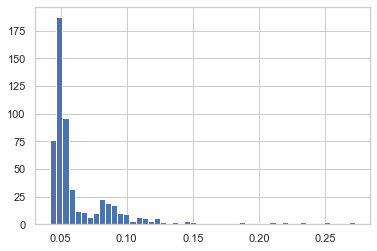

In [26]:
plt.hist(merged_df['Ratio'], bins=50);

Here we see that the ```Ratio``` variable is largely clustered around 0.05, with some large values that extend upward to 0.25, though these higher values are not common (hence they have a bar with a smaller height in the histogram).  

Is there something that combines a visual for the distribution of the data with the summary statistics? There is! The **boxplot** allows us to observe whether significant extreme values are present in the data and can help us determine if the data has a large variance or is skewed.

Since we saw a cyclical pattern in the line plot analysis preceding this section, let's take a closer look at how the distribution of the ratio of consumed to generated energy evolves over the different months of the year. We will do so by creating a series of side-by-side boxplots, one per month:

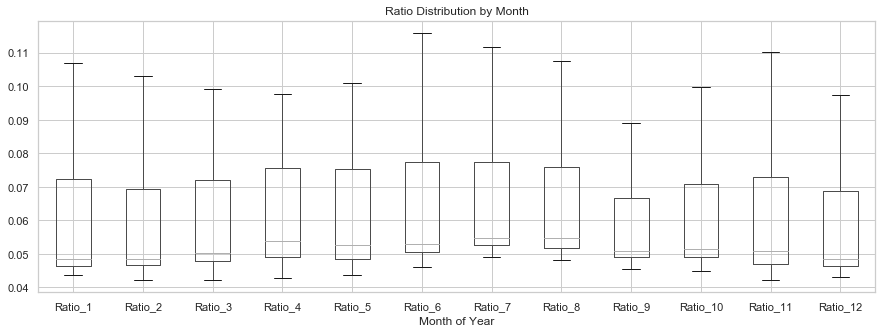

In [27]:
# Select months to use
unique_months = range(1,13)

# Loop through all months and store each DataFrame in list
df_list = []
for month_int in unique_months:
    temp_df = merged_df[merged_df['MM'] == month_int][['Ratio']].reset_index(drop=True) # Select month
    temp_df = temp_df.rename(columns={'Ratio':'Ratio_'+str(month_int)}) # rename for ease of plotting
    df_list.append(temp_df) # store for later concatenation

# Aggregate data
plot_df = pd.concat(df_list, axis=1)

# Box plots
fig, ax = plt.subplots(figsize=(15,5))
plot_df.boxplot(ax=ax, showfliers=False)
ax.set_xlabel('Month of Year');
ax.set_title('Ratio Distribution by Month');

Each boxplot consists of an inner box, and two "whiskers" on either side. The central horizontal line in the middle of the box correponds to the median of the data that the boxplot represents, while the upper and lower edges of the box represent the 75th percentile and 25th percentile of the data, respectively. The whiskers are drawn at either 1.5 times the **interquartile range (IQR)** from the edges of the box or at the min/max values in the data, whichever is closer. The IQR is the difference between the 75th percentile value and the 25th percentile value.

### Exercise 5 (4 min):

Recall the ratio is the energy consumed (PEC Electric Power Sector) divided by the energy generated (ENG Nuclear Electric Power). What patterns do you notice in this ratio from the plots above? What could be a possible reason for these patterns? What might you recommend to your boss based on this?

**Answer.** Here, we see a pattern of higher ratios in the summer months, particularly July (month 7) and August (month 8), as the boxes in the box plot shift upward in summer months, and subsequently shift downward in winter months.

The summer months lead to increased energy consumption directed towards cooling capacity due to high temperatures across the U.S. The amount of power being generated does not increase as much as the energy being consumed does, so there is an upward trend in the ratio of consumed to generated energy. From this, it may the case that a nuclear plant is justified to provide marginal quantities of energy to meet demand (however, there is more research you need to do to validate this hypothesis).

Now that we've seen some of Python's basic data visualization tools, let's begin to explore these cyclical peaks in the summer months using a second, highly useful package: ```seaborn```.

## Using ```seaborn``` for advanced visualization of the identified cyclical patterns (3 min)


While ```matplotlib``` is a nice plotting package, it is meant to be a general plotting tool for many use cases. ```seaborn``` is an extremely useful data visualization library specifically deisgned for statistical figures. We will go through some important plotting functionality while continuing to identify trends in the energy data. We will only be scratching the surface of ```seaborn``` but [here](https://seaborn.pydata.org/api.html) is a list of all the possible plots.

To further explore the cyclical patterns identified in the summer months, let's label the rows in the ```merged_df``` that represent summer months (call them peak months) and use seaborn's plots to visualize the distributional differences in energy consumed and electricity generated between the peak and non-peak months:

In [28]:
# Add a flag for summer months
customized_df = merged_df.copy()
customized_df['PEAK_FLAG'] = customized_df['YYYYMM'].apply(lambda x: 'PEAK' if str(x)[-2:] in ['07','08'] else 'NOT PEAK')

## Are peak consumption and generation months consistent across many years? (5 min)

Let's now look at consumption and generation levels month-by-month level over time to see if the peak cyclical patterns we see are stable across many decades of data.

```seaborn``` offers a powerful [**heatmap**](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap) method ```heatmap()``` that will allow us to nicely visualize the monthly energy consumed and electricity generated over time:

In [29]:
# Extract year to be used in heatmap
customized_df['YYYY'] = customized_df['YYYYMM'].apply(lambda x: str(x)[:-2])

# Create pivot table (formats data to make it easy to visualize data across months and years)
pivot_elec_df = customized_df.pivot('MM','YYYY','Value_GENERATE')
pivot_ener_df = customized_df.pivot('MM','YYYY','Value_CONSUME')

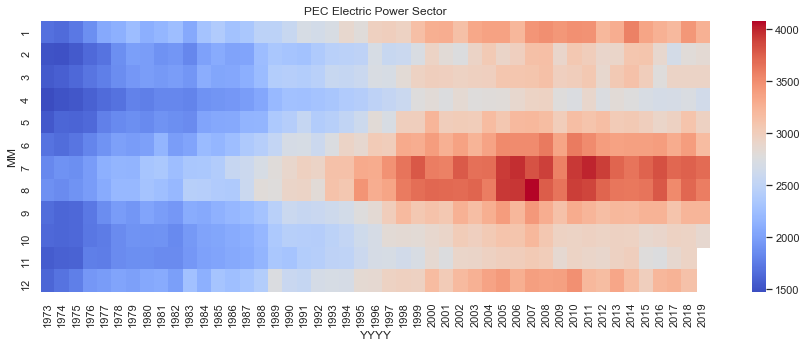

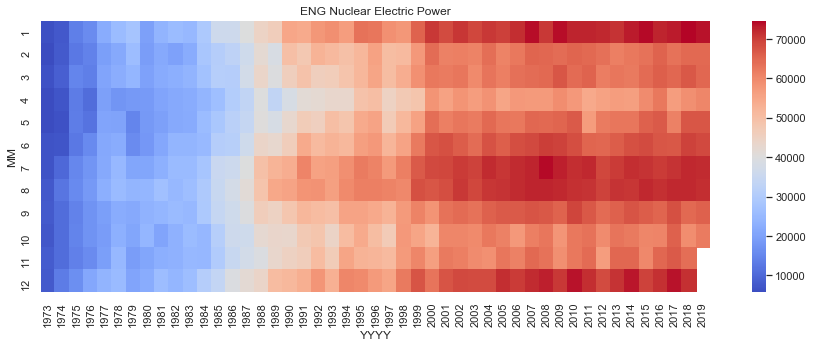

In [30]:
# Heat map of energy consumption by month and year
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(pivot_ener_df, cmap="coolwarm", ax=ax);
ax.set_title('PEC Electric Power Sector');

# Heat map of electricity generation by month and year
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(pivot_elec_df, cmap="coolwarm", ax=ax);
ax.set_title('ENG Nuclear Electric Power');

The color bar on the right indicates the level of the variable under study. Using the heatmap, it is easy to see that there is a notable increase in both energy consumption and generation in the peak summer months that began in the 1990s. However, in the earlier years (before 1990) the difference between the peak summer months and other months is not as marked (although it still exists). This may be due to the increase in usage of cooling units in the past few decades.

Additionally, we see the overall energy consumed and electricity generated over time is increasing. This is indicated by the colors moving from blue to red in both heat maps as the years go by. This is expected, as aggregate demand has increased due to numerous outside factors, such as population growth and increased technology usage, both of which lead to increased energy demand and electricity supply. 

These heatmaps are enormously useful for identifying big, sweeping trends over time. However one downside of these heatmaps is that it is tough to be more granular and see changes in growth rates from year to year. Let's build a boxplot to better understand if growth is stable across time, and whether this translates to growth in both the peak and non-peak months.

## Assessing growth stability  differences in peak month energy demands across time (8 min)

One way to better understand growth stability of energy consumption and electricity generation is to view distributional data over time. We will do so by combining boxplots for each year, splitting for peak and non-peak months, and determine how stable the growth, consumption, and generation categories have been.

This time, we will use seaborn's ```boxplot()``` functionality (which is more colorful than the version in `pandas`), and we will add a flag to draw two boxplots for each year based on ```PEAK_FLAG```. The boxplots for peak and non-peak months will be different colors. You can find the boxplot API [here](https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot).

### Exercise 6 (6 min):

Focusing on ```customized_df```, write a script to generate the plot below.

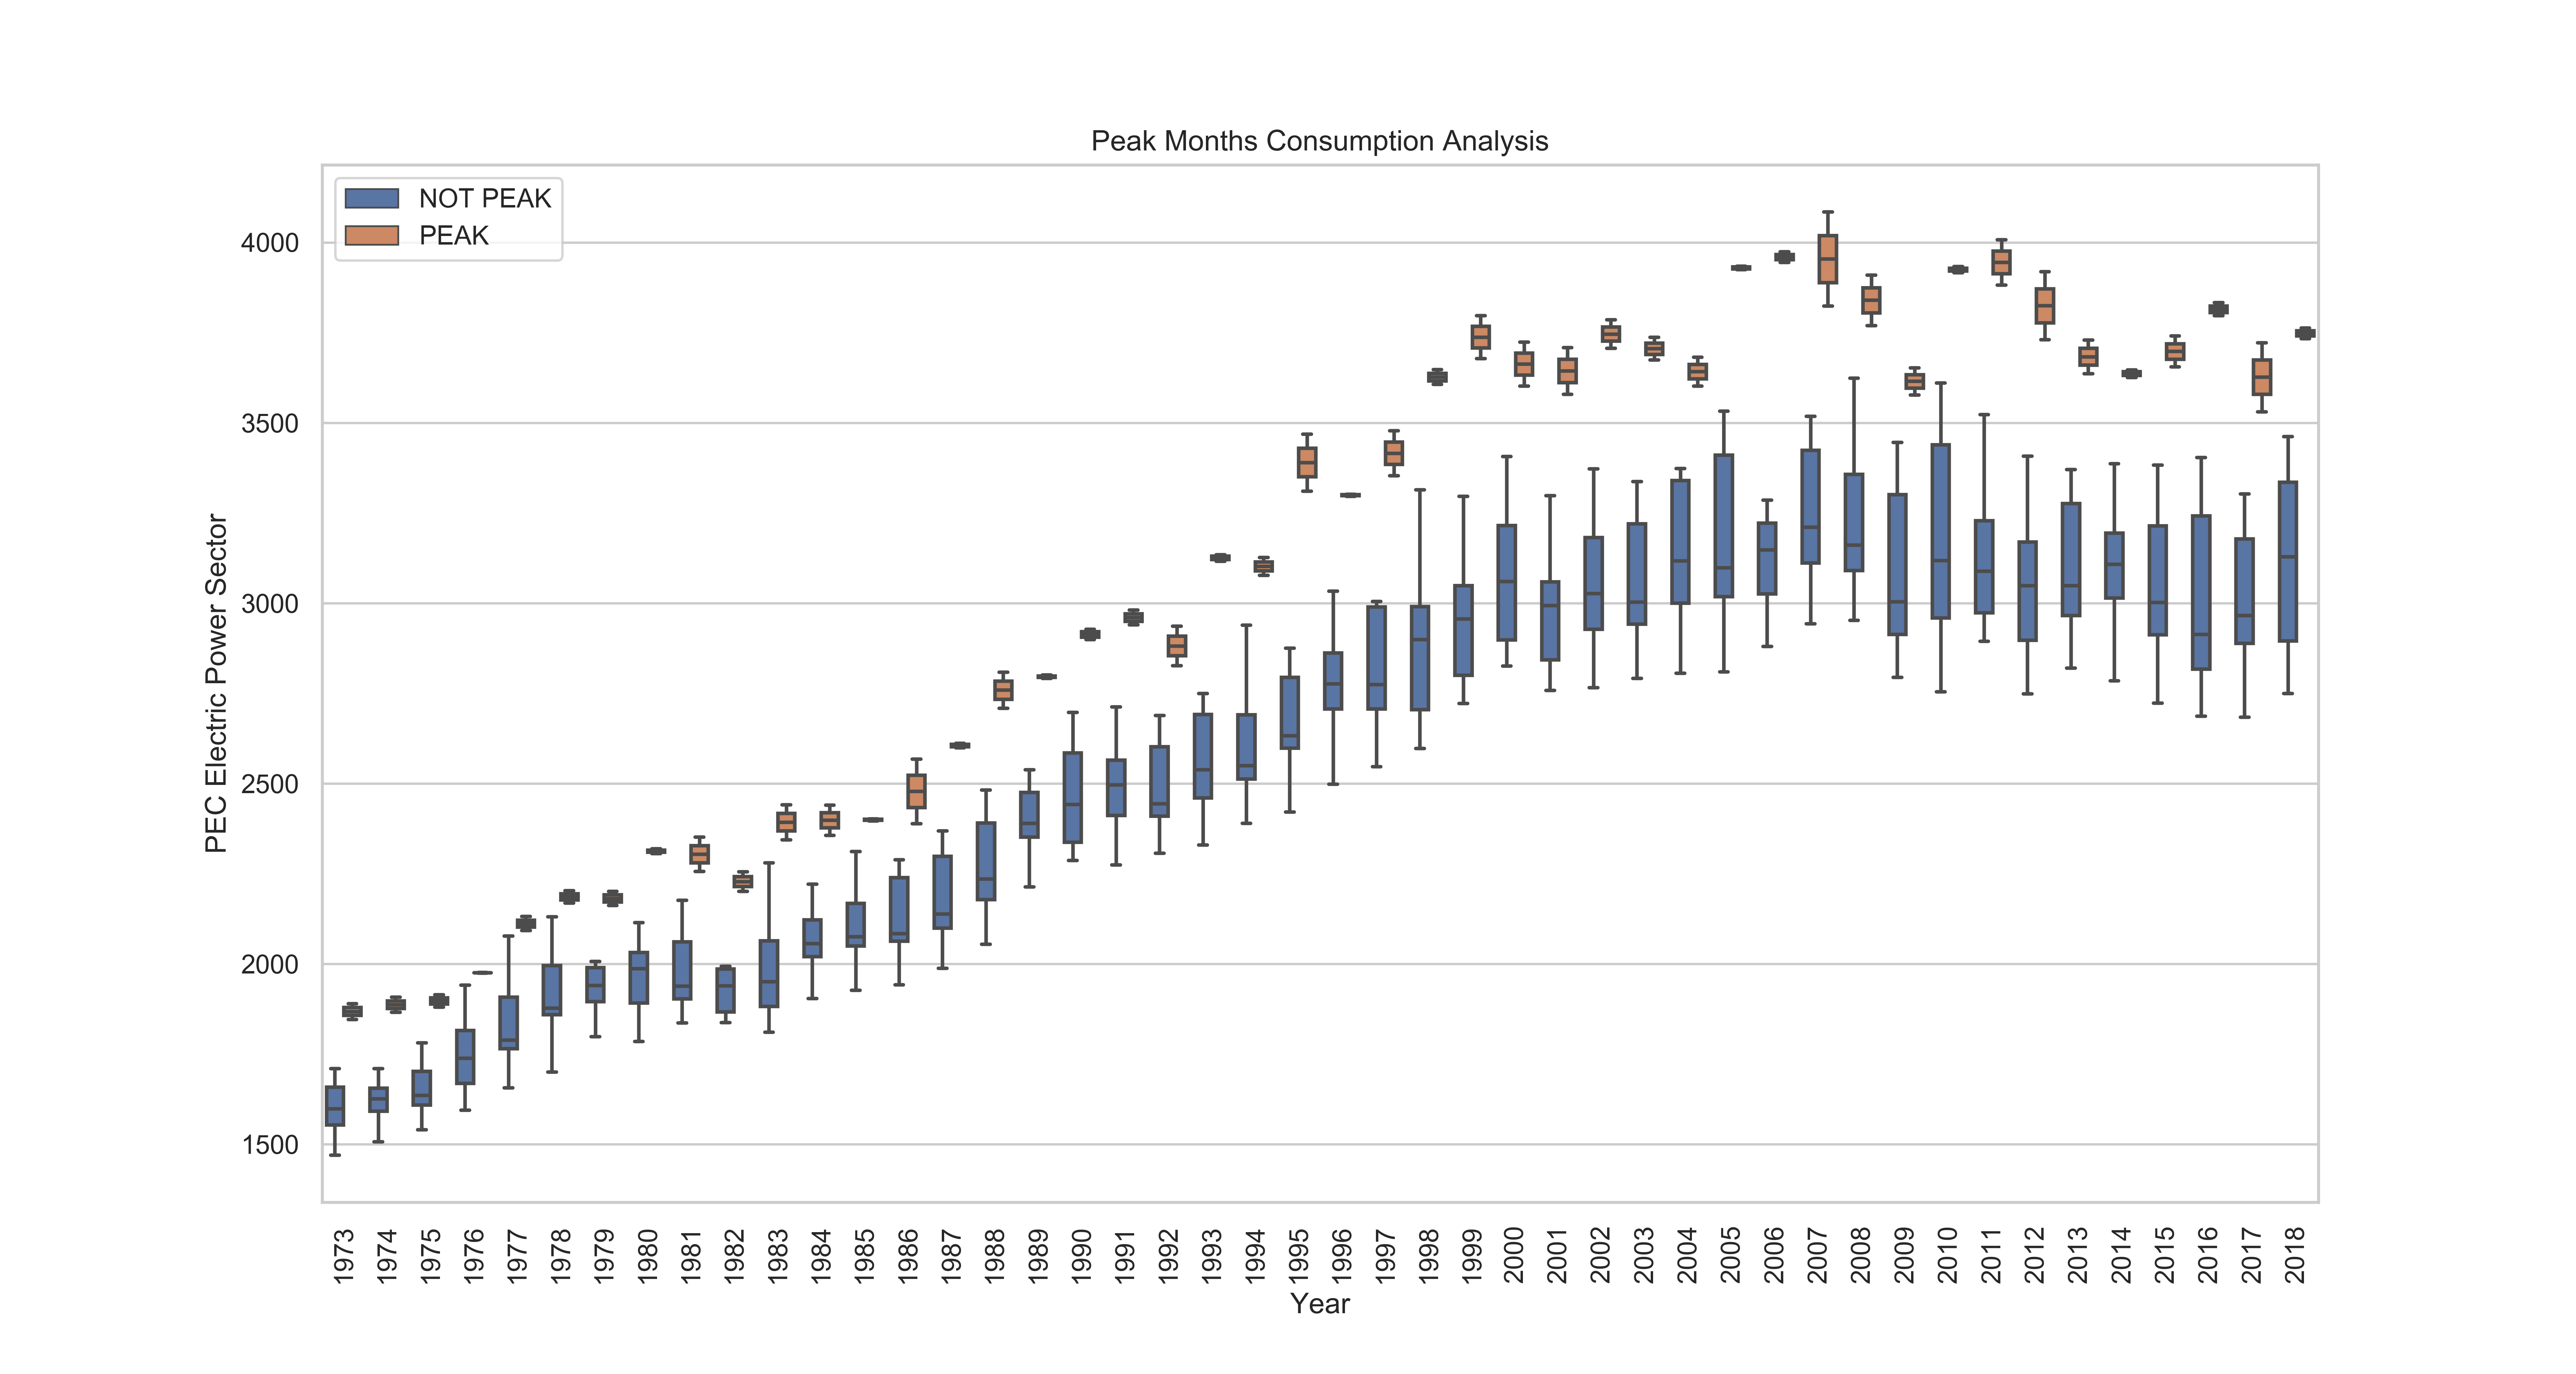

In [31]:
Image("data/ExampleImage.png")

**Answer.** One possible solution is shown below:

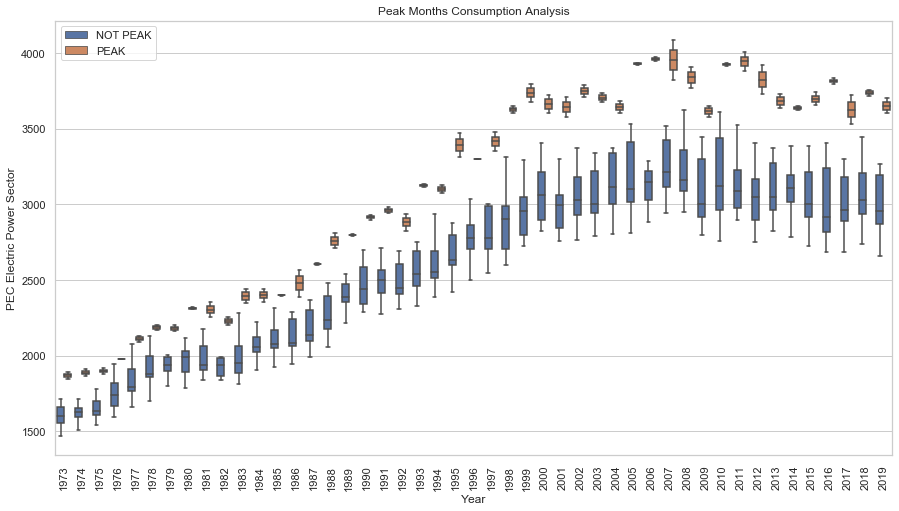

In [32]:
# Define figure size, create plot
fig, ax = plt.subplots(figsize=(15,8))
m = sns.boxplot(x="YYYY",y="Value_CONSUME",hue='PEAK_FLAG',data=customized_df,orient='vertical',showfliers=False)

# Format plot
plt.legend(loc='upper left')
plt.title('Peak Months Consumption Analysis')
plt.xticks(rotation=90);
plt.xlabel('Year')
plt.ylabel('PEC Electric Power Sector');

Here we see that growth in both peak and non-peak months has been relatively stable but in recent years has plateaued. Also notice that the difference between peak and non-peak months has widened over time. This increased fluctuation between peak and non-peak months could present an opportunity for nuclear energy and is worth further investigation.

We've looked closely at the changes in nuclear electric power generation and consumption over time. Let's now shift towards the second part of your boss's request by looking at consumption patterns across sectors. This has important implications for how the government should allocate resources for the nuclear power.

## Which sectors consume the most energy? (3 min)

We can answer this question easily with ```seaborn```'s ```boxplot()``` functionality, which splits the data into categories and creates a boxplot of values for each category:

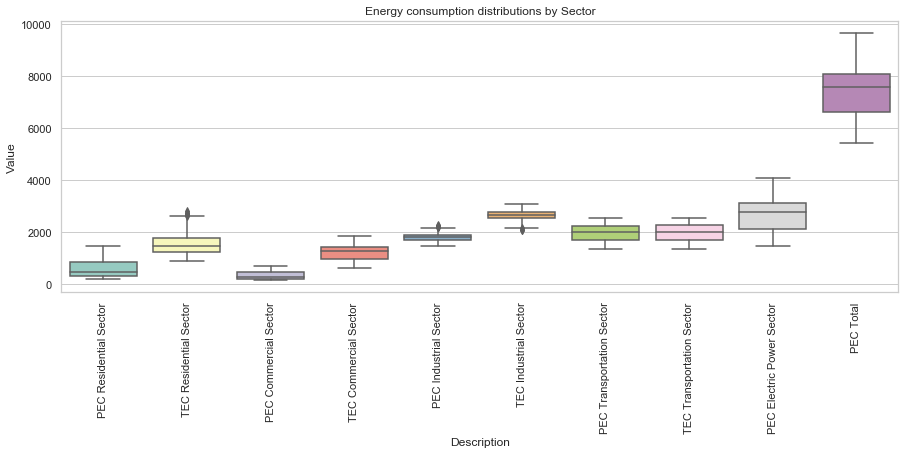

In [33]:
# Boxplot of different sectors' energy consumption values
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x="Description", y="Value", data=clean_energy_df, palette="Set3", ax=ax)
plt.xticks(rotation=90);
plt.title('Energy consumption distributions by Sector');

Here we see that the PEC Electric Power Sector has the highest energy consumption across all sectors. We also see there are sizable differences in the variability of energy consumption across sectors (some box plots have much larger interquartile ranges than others).

However, although boxplots give you some insight into the distribution of the underlying data in each category, they are still relatively blunt instruments. For example, how is the data distributed within the interquartile range? Between the edges of the box and the whiskers? Since a boxplot is created from only five values, it cannot answer these fine-grained questions. However, the **strip plot** is able to combine a 1D scatterplot with a split by category to get an even more granular view of the data.

## A more granular view of energy consumption by sector (6 min)

```stripplot()``` in ```seaborn``` creates a series of 1D scatterplots (one for each data category) all sharing the same y-axis. As you will see, ```seaborn``` makes the API similar across the plots. ```stripplot()``` API can be found [here](https://seaborn.pydata.org/generated/seaborn.stripplot.html#seaborn.stripplot):

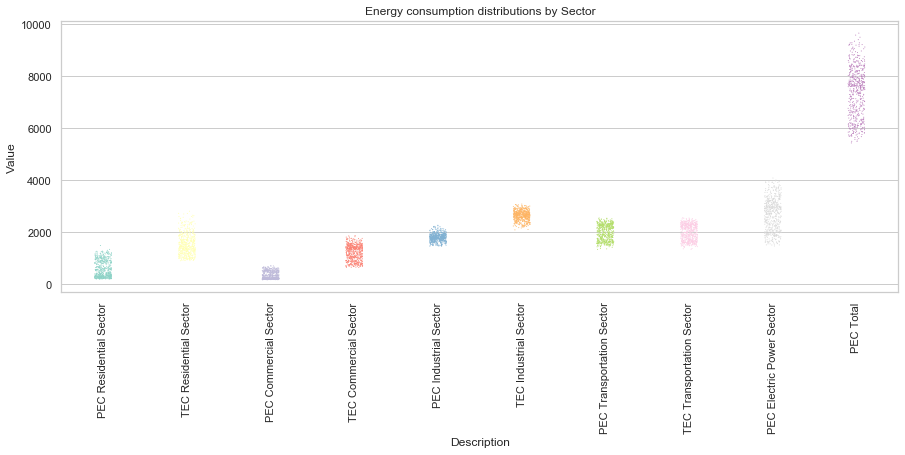

In [34]:
# Create a stripplot() of the data for a nice granular view
fig, ax = plt.subplots(figsize=(15,5))
m = sns.stripplot(x="Description", y="Value", data=clean_energy_df, palette="Set3", s=1, ax=ax)
plt.xticks(rotation=90);
plt.title('Energy consumption distributions by Sector');

### Exercise 7 (4 min):

From the above graphs, which of the sectors has the widest range of PEC values? Which of the sectors has the smallest range of PEC values? How could this information be useful to energy production companies?

**Answer.** The widest range of values appears to be the electric power sector, while the smallest range of values comes from the commercial sector. The information on the spread of energy usage can be very important to companies to ensure they have adequate infrastructure in place to meet the varying demand of energy consumption. If there is a wide range of energy consumption over time, the energy producing companies must have a scalable infrastructure, while maintaining the ability to expand capacity when needed to meet excess energy demand.

Now, on to our final task – how do we generate files for these plots so that they can be used in your boss's presentation?

# Programmatic plot generation (12 min)

Let's take a look at how to create plots of values for each energy consumption sector, in addition to how to programatically add a folder where we will save the plots as PNG files:

In [35]:
# Construct DataFrame that will be used for plotting
plot_df = clean_energy_df.copy()
plot_df['YYYYMM_dt'] = plot_df['YYYYMM'].apply(lambda x: datetime.datetime.strptime(str(x), "%Y%m"))
plot_df.head()

,YYYYMM,Value,Description,Unit,MM,YYYY,YYYYMM_dt
24,197301,1339.270,PEC Residential Sector,Trillion Btu,1,1973,1973-01-01
25,197302,1174.899,PEC Residential Sector,Trillion Btu,2,1973,1973-02-01
26,197303,983.374,PEC Residential Sector,Trillion Btu,3,1973,1973-03-01
27,197304,715.391,PEC Residential Sector,Trillion Btu,4,1973,1973-04-01
28,197305,535.914,PEC Residential Sector,Trillion Btu,5,1973,1973-05-01


Now let's make a folder called ```data/PlotDir``` where will we save the plots in PNG files:

In [36]:
# Make new folder to save plots
plot_dir = os.path.join(os.getcwd(), 'data/PlotDir')

# Only make new folder if it doesn't already exist
if not(os.path.isdir(plot_dir)):
    os.mkdir(plot_dir) # creates new folder

Finally, loop over all the energy consumption sectors, create line plots, and save the figures:

In [37]:
# One can quickly generate and save plots with ease in Juypter
unique_desc = sorted(plot_df['Description'].unique())
for i in unique_desc:
    fig, ax = plt.subplots(figsize=(15,4))
    temp_df = plot_df[plot_df['Description'] == i]
    ax.plot(temp_df['YYYYMM_dt'], temp_df['Value'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m')) # format x-axis display

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Data Description: ' + str(i))
    plt.tight_layout()
    
    # Save to png
    file_name = 'SectorPlot ' + str(i) + '.png'
    print("Saving: " + file_name)
    fig.savefig(os.path.join(plot_dir,file_name)) # save to png (save in plot_dir)
    plt.close(fig) # Do not print plots to notebook (large number of plots can take up significant memory)

Saving: SectorPlot PEC Commercial Sector.png
Saving: SectorPlot PEC Electric Power Sector.png
Saving: SectorPlot PEC Industrial Sector.png
Saving: SectorPlot PEC Residential Sector.png
Saving: SectorPlot PEC Total.png
Saving: SectorPlot PEC Transportation Sector.png
Saving: SectorPlot TEC Commercial Sector.png
Saving: SectorPlot TEC Industrial Sector.png
Saving: SectorPlot TEC Residential Sector.png
Saving: SectorPlot TEC Transportation Sector.png


We've saved the results in the ```data/PlotDir``` folder. Each plot has been created with the same general code structure, ensuring the resulting plots are the same format, even though each one contains a different sector's data. This programmatic method of generating plots is highly useful when creating systematic data visualization procedures in both simple and complex data investigations.

### Exercise 8 (10 min):

Write a script to generate a plot of stripplots of ```Value``` for each year in ```clean_energy_df```, where the stripplots are created from the values of each sector category from ```Description``` . For example, the stripplot for year 2000 is below. Save the plots in PNG files in a new folder ```data/YearlyStripplotDir``` (create this), and name the figures in the format ```YearlyStripplot_[yearnum].png```, where you replace ```[yearnum]``` with the correct year. For example, the year 2000 stripplot is saved as ```data/YearlyStripplot_2000.png```. You must produce one stripplot figure for each year from 1973 to 2018; hence, you will have one PNG image file per year.

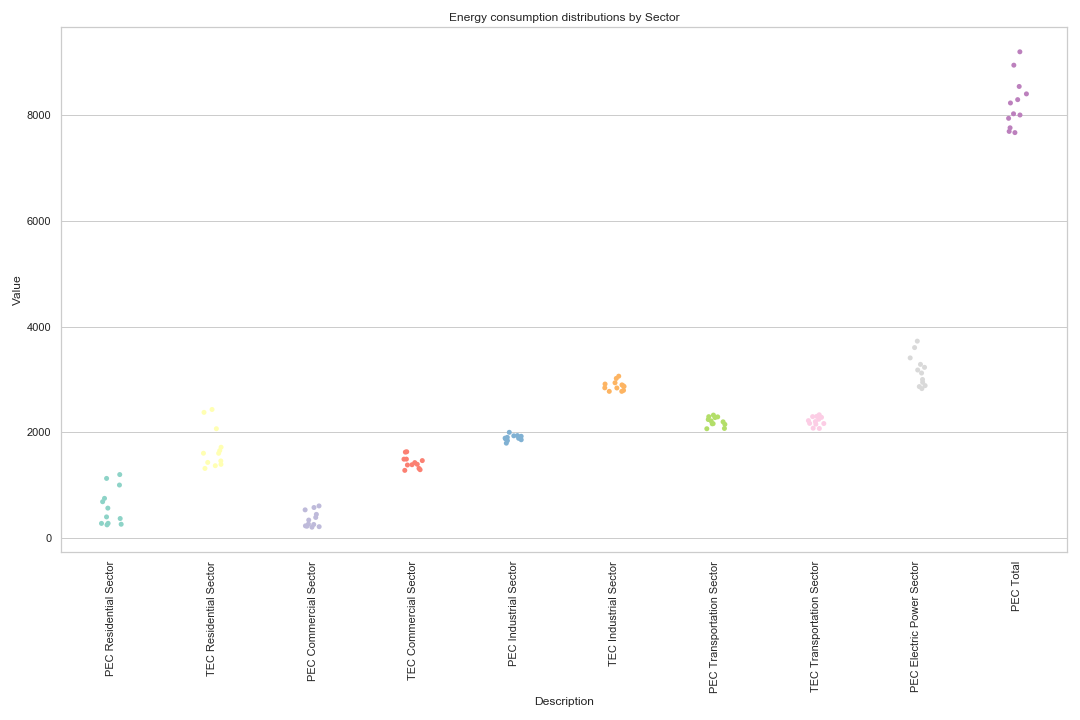

In [38]:
# Example of one of the years stripplot figures
Image("data/YearlyStripplot_2000.png")

**Answer.** One possible solution is shown below:

In [39]:
# Make new folder to save plots
stripplot_dir = os.path.join(os.getcwd(), 'data/YearlyStripplotDir')

# Only make new folder if it doesn't already exist
if not(os.path.isdir(stripplot_dir)):
    os.mkdir(stripplot_dir) # creates new folder

# Get unique years to loop over
unique_years = sorted(clean_energy_df['YYYY'].unique())

for i in unique_years:
    # Stripplot of different sectors' energy consumption values
    fig, ax = plt.subplots(figsize=(15,10))
    sns.stripplot(x="Description", y="Value", data=clean_energy_df[clean_energy_df['YYYY'] == i], palette="Set3", ax=ax)
    plt.xticks(rotation=90);
    plt.title('Energy consumption distributions by Sector')
    plt.tight_layout()
    
    # Save to png
    file_name = 'YearlyStripplot_' + str(i) + '.png'
    print("Saving: " + file_name)
    fig.savefig(os.path.join(stripplot_dir,file_name)) # save to png (save in plot_dir)
    plt.close(fig) # Do not print plots to notebook (large number of plots can take up significant memory)

Saving: YearlyStripplot_1973.png
Saving: YearlyStripplot_1974.png
Saving: YearlyStripplot_1975.png
Saving: YearlyStripplot_1976.png
Saving: YearlyStripplot_1977.png
Saving: YearlyStripplot_1978.png
Saving: YearlyStripplot_1979.png
Saving: YearlyStripplot_1980.png
Saving: YearlyStripplot_1981.png
Saving: YearlyStripplot_1982.png
Saving: YearlyStripplot_1983.png
Saving: YearlyStripplot_1984.png
Saving: YearlyStripplot_1985.png
Saving: YearlyStripplot_1986.png
Saving: YearlyStripplot_1987.png
Saving: YearlyStripplot_1988.png
Saving: YearlyStripplot_1989.png
Saving: YearlyStripplot_1990.png
Saving: YearlyStripplot_1991.png
Saving: YearlyStripplot_1992.png
Saving: YearlyStripplot_1993.png
Saving: YearlyStripplot_1994.png
Saving: YearlyStripplot_1995.png
Saving: YearlyStripplot_1996.png
Saving: YearlyStripplot_1997.png
Saving: YearlyStripplot_1998.png
Saving: YearlyStripplot_1999.png
Saving: YearlyStripplot_2000.png
Saving: YearlyStripplot_2001.png
Saving: YearlyStripplot_2002.png
Saving: Ye

## Conclusions (3 min)

We've done an extensive analysis of energy consumption and electricity generation trends over time and across sectors.

We discovered that there is a peak in energy consumption and generation in the summer months of the year, and as time has passed the gap between peak and non-peak consumption has widened. This may present a market opportunity for a power plant which has the ability to expand and contract capacity as needed.

Finally, we saw that different sectors have very different energy consumption profiles. In particular, the electric power sector seems to be a significant driver of marginal demand. This means that the DoE might want to focus its efforts on reducing consumption in this sector or providing additional generation if it is suspect

## Takeaways (5 min)

In this case, we extended the basics of the ```pandas``` library in Python and built a foundation for creating visualizations using ```matplotlib``` and ```seaborn```. Specifically we:

1. Cleaned data from the EIA to fit our visualization needs
2. Performed basic lineplots with ```matplotlib```
3. Enhanced our visualizations using ```seaborn```
4. Automated the creation and saving of these plots for easy sharing

Visualization is a powerful tool in the data professional's toolbelt for effective data exploration and communication. It helps you find interesting trends in your data that you would otherwise not notice. It is also used to clearly show your findings to non-technical people. As such, it is an important skill for you to practice and develop.

As we have only scratched the surface of ```seaborn```'s capabilities, we highly recommend going through the ```seaborn``` documentation to understand what types of plots that are available. You should also plot them yourself using various data sources so that you begin to understand which plots are useful for what types of data (time series, categorical, etc.) and for what contexts of data (spotting trends, effective communication, etc.)